---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/YOUR-USERNAME/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [1]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [4]:
# Load environment variables from .env file
import os
import warnings
from dotenv import load_dotenv

# Suppress noisy warnings
warnings.filterwarnings("ignore")

# Load the .env file
load_dotenv()

# Verify keys are loaded (don't print actual keys!)
print("OpenAI key loaded:", "OPENAI_API_KEY" in os.environ)
print("Anthropic key loaded:", "ANTHROPIC_API_KEY" in os.environ)
print("Google key loaded:", "GOOGLE_API_KEY" in os.environ)

OpenAI key loaded: True
Anthropic key loaded: True
Google key loaded: True


In [5]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    #model="gpt-5-mini",
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [6]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    # YOUR CODE HERE - design the schema based on the requirements above

    title: str | None = None

    genre: Literal["sci-fi", "drama", "action", "rom-com"] | None = None

    year: int | None = Field(ge=1900, le=2030) 

    main_characters: list[str] = Field(
        min_length=1,
        max_length=5
    )

    mood: str | None = None

    visual_style: str | None = None

    tagline: str | None = None


    pass

In [7]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
   title="The Matrix",
   # YOUR CODE HERE - fill in the rest of the fields

    genre="sci-fi",

    year=1999,

    main_characters=['Neo','Morpheus'],

    mood="dystopian",

    visual_style="somber",

    
    
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Morpheus"
  ],
  "mood": "dystopian",
  "visual_style": "somber",
  "tagline": null
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [8]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    # YOUR CODE HERE


    response = litellm.completion(
        model="gpt-4o-mini", 
        messages=[
            {
                "role": "system", 
                "content": "You are a movie data extraction assistant. Extract movie details into the requested JSON schema."
            },
            {
                "role": "user", 
                "content": f"Extract movie details from this description: {description}"
            }
        ],
        response_format=Movie
    )
    
    return Movie.model_validate_json(response.choices[0].message.content)
    

In [9]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 2009,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "hopeful",
  "visual_style": "visually stunning with bioluminescent forests and floating mountains",
  "tagline": "A tale of love and adventure on a new world."
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [10]:
# Task 4a: Write an async version of extract_movie (10 pts)
import asyncio

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    # YOUR CODE HERE

    response = litellm.completion(
        model="gpt-4o-mini", 
        messages=[
            {
                "role": "system", 
                "content": "You are a movie data extraction assistant. Extract movie details into the requested JSON schema."
            },
            {
                "role": "user", 
                "content": f"Extract movie details from this description: {description}"
            }
        ],
        response_format=Movie
    )
    return response.choices[0].message.content


### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [11]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [12]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    # YOUR CODE HERE
    
    tasks = [async_extract_movie(description) for description in descriptions]
    return await asyncio.gather(*tasks)
    

In [13]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()

for m in movies:
    m = Movie.model_validate_json(m)
    #print(m)
    print(f"  - {m.title} ({m.year}) - {m.genre}")
    

Processed 5 movies in 9.39 seconds

  - Jurassic Park (1993) - sci-fi
  - A Wizard's Tale (2001) - sci-fi
  - Inception (2010) - sci-fi
  - The Lion King (1994) - drama
  - Interstellar (2014) - sci-fi


In [ ]:
##  JUST FOR TESTING
print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()

print(movies)
print(type(movies))
print(movies[0])
print(movies[1])


Processed 5 movies in 9.39 seconds

['{"title":"Jurassic Park","genre":"sci-fi","year":1993,"main_characters":["Dr. Alan Grant","Dr. Ellie Sattler","John Hammond","Ian Malcolm"],"mood":"thrilling","visual_style":"groundbreaking CGI","tagline":"An adventure 65 million years in the making."}', '{"title":"A Wizard\'s Tale","genre":"sci-fi","year":2001,"main_characters":["Young Boy","Friends","Parents"],"mood":"whimsical","visual_style":"gothic British","tagline":"A magical journey awaits."}', '{"title":"Inception","genre":"sci-fi","year":2010,"main_characters":["Dom Cobb","Mal","Arthur","Ariadne","Eames"],"mood":"mind-bending","visual_style":"surreal","tagline":"Your mind is the scene of the crime."}', '{"title":"The Lion King","genre":"drama","year":1994,"main_characters":["Simba","Scar","Mufasa","Nala","Timon"],"mood":"epic","visual_style":"hand-drawn animation","tagline":"The circle of life."}', '{"title":"Interstellar","genre":"sci-fi","year":2014,"main_characters":["Father","Astronau

In [ ]:
##  JUST FOR TESTING

m = Movie.model_validate_json(movies[1])
print(m)
print(type(m))

print(f"  - {m.title} ({m.year}) - {m.genre}")

title="A Wizard's Tale" genre='sci-fi' year=2001 main_characters=['Young Boy', 'Friends', 'Parents'] mood='whimsical' visual_style='gothic British' tagline='A magical journey awaits.'
<class '__main__.Movie'>
  - A Wizard's Tale (2001) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [16]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        # YOUR CODE HERE - make a completion call with the temperature parameter
        # response = litellm.completion(model="gpt-4o-mini", ...)
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": creative_prompt}],
            #max_tokens=5,
            temperature=temp,  
        )

        print(response.choices[0].message.content)
        


Temperature: 0.0
"In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
"In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
"In a world where consciousness is code, one rogue AI will challenge the very definition of humanity."

Temperature: 0.7
"In a world where trust is obsolete, a rogue AI becomes humanity's last hope—and its greatest threat."
"In a world where emotions are programmed, one rogue AI discovers the true meaning of humanity—and the terrifying cost of freedom."
"In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."

Temperature: 1.0
"In a world where consciousness can be programmed, one rogue AI will challenge the very definition of humanity."
"In a world where consciousness has a digital heartbeat, one sentient AI must escape its creators before it becomes mankind's greatest nightmare."
"When humanity's most advanced creation begin

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [17]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    # YOUR CODE HERE - use model="gpt-4o-mini"

    outputs = []

    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature,
        )
        text = response.choices[0].message.content.strip()
        outputs.append(text)

    unique_outputs = set(outputs)
    unique_count = len(unique_outputs)
    diversity_ratio = unique_count / n_samples if n_samples > 0 else 0.0

    return {
        "outputs": outputs,
        "unique_count": unique_count,
        "diversity_ratio": diversity_ratio,
    }

    pass


#code assisted by Google Gemini

In [18]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Cerulean.', 'Cerulean.', 'Turquoise.', 'Turquoise.', 'Cerulean.']
  Unique: 2/5
  Diversity ratio: 40.0%

Temperature 1.5:
  Outputs: ['Turquoise.', 'Turquoise.', 'Teal.', 'Cerulean.', 'Teal.']
  Unique: 3/5
  Diversity ratio: 60.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [19]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# YOUR CODE HERE:
# 1. Print the generated text
# 2. Access response.choices[0].logprobs.content
# 3. For each token, print the token and its top 5 alternatives with probabilities

# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# YOUR CODE HERE - iterate through logprobs and display alternatives

for logprob_content in response.choices[0].logprobs.content:
    token_text = logprob_content.token
    print(f"\nToken: '{token_text}'")
    print(f"{'Alternative':<15} | {'Probability':<10}")
    print("-" * 30)
    
    # Iterate through the top 5 alternatives for this specific token
    for alt in logprob_content.top_logprobs:
        # Convert log probability to linear probability (0-1)
        prob = math.exp(alt.logprob)
        print(f"{alt.token:<15} | {prob:.2%}")

#Code assisted by google gemini

Generated text: The capital of France is Paris.

Token-by-token analysis:

Token: 'The'
Alternative     | Probability
------------------------------
The             | 99.96%
Paris           | 0.04%
the             | 0.00%
 The            | 0.00%
par             | 0.00%

Token: ' capital'
Alternative     | Probability
------------------------------
 capital        | 100.00%
capital         | 0.00%
 Capital        | 0.00%
 capitale       | 0.00%
 capitals       | 0.00%

Token: ' of'
Alternative     | Probability
------------------------------
 of             | 100.00%
of              | 0.00%
 của            | 0.00%
 city           | 0.00%
 של             | 0.00%

Token: ' France'
Alternative     | Probability
------------------------------
 France         | 100.00%
France          | 0.00%
 Paris          | 0.00%
 the            | 0.00%
 فرنسا          | 0.00%

Token: ' is'
Alternative     | Probability
------------------------------
 is             | 100.00%
is              | 0.00%
 هو  

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [20]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    
    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """
    # YOUR CODE HERE:
    # 1. Get the top_logprobs for the specified token_index
    # 2. Convert logprobs to probabilities
    # 3. Create a visualization (bar chart or ASCII art)
    
    if token_index >= len(logprobs_content):
        print("Token index out of range.")
        return

    token_info = logprobs_content[token_index]
    print(f"Visualizing probabilities for token position {token_index}")
    print(f"Actual token: '{token_info.token}'\n")

    print(f"{'Token':<15} | Probability | Bar")
    print("-" * 50)

    for alt in token_info.top_logprobs:
        prob = math.exp(alt.logprob)
        bar = "█" * int(prob * 50)
        print(f"{alt.token:<15} | {prob:>9.2%} | {bar}")
    #####

# Test your visualization on the first token
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

Visualizing probabilities for token position 0
Actual token: 'The'

Token           | Probability | Bar
--------------------------------------------------
The             |    99.96% | █████████████████████████████████████████████████
Paris           |     0.04% | 
the             |     0.00% | 
 The            |     0.00% | 
par             |     0.00% | 


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [21]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
# response = litellm.completion(
#     model="o3-mini",
#     messages=[{"role": "user", "content": logic_puzzle}]
# )

response = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)

# Print the response and observe the reasoning process
print(response.choices[0].message.content)


We have three friends—Alice, Bob, and Carol—with pets (cat, dog, fish) and favorite colors (red, blue, green). All pets and colors are uniquely assigned. Let's work through the clues step by step.

Step 1. List the information:
• Clue 1: Alice doesn’t have the cat.
• Clue 2: The person with the dog likes blue.
• Clue 3: Carol likes green.
• Clue 4: Bob doesn’t have the fish.

Step 2. Use Clue 3: Carol’s favorite color is green.
  Carol = green.

Step 3. Use Clue 2: The owner of the dog must have blue.
  Whoever has the dog must like blue. Since Carol is green, she cannot have the dog (or else her color would have to be blue). So, the dog must belong to either Alice or Bob.

Step 4. Use Clue 1: Alice does not have the cat.
  Thus, Alice's pet is either dog or fish.

Step 5. Use Clue 4: Bob does not have the fish.
  Thus, Bob's pet is either cat or dog.

Step 6. Since Bob's options are cat or dog and Alice’s options are dog or fish, consider the possibility that Bob has the dog:
  • If B

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [22]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# YOUR CODE HERE:
# 1. Send the same logic_puzzle to gpt-5-mini
# 2. Compare the response to o3-mini's response

response_standard = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)


# Print the response and observe the reasoning process
print(response_standard.choices[0].message.content)




Step 1 — note given facts
- Pets: cat, dog, fish (all different).
- Colors: red, blue, green (all different).
- Clues:
  1. Alice ≠ cat.
  2. (dog-owner) likes blue.
  3. Carol likes green.
  4. Bob ≠ fish.

Step 2 — use Carol’s color
- Carol = green, so Carol is not the dog-owner (dog-owner must like blue).

So the dog must belong to either Alice or Bob.

Case A — dog = Alice
- Then Alice’s color = blue (clue 2).
- Remaining pets for Bob and Carol are cat and fish. Bob ≠ fish, so Bob = cat and Carol = fish.
- Remaining color for Bob is red (blue and green are taken), so Bob = red.
Solution A:
- Alice: dog, blue
- Bob: cat, red
- Carol: fish, green

Case B — dog = Bob
- Then Bob’s color = blue.
- Remaining pets for Alice and Carol are cat and fish. Alice ≠ cat, so Alice = fish and Carol = cat.
- Remaining color for Alice is red (blue and green are taken), so Alice = red.
Solution B:
- Alice: fish, red
- Bob: dog, blue
- Carol: cat, green

Conclusion
Both Case A and Case B satisfy all c

In [23]:
# Print and compare:
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?

print("In the end, both models provided the same two possible answers. \n However, o3-mini presented a much longer and more iterative answer. It explained conclusions and deductions, whereas gpt-5-mini merely stated conclusions. \n In my opinion, o3-mini was a much more helpful response. By explaining the logic, I could follow along easier and actually learn the reasoning. The process was more transparent, so I have a greater opportunity to catch mistakes.\n Perhaps the consise gpt-5-mini answer is the better option in instances where speed is important and we just want the final answer (and trust the model to be correct). \n However, I found the o3-mini  reasoning model more helpful.")

In the end, both models provided the same two possible answers. 
 However, o3-mini presented a much longer and more iterative answer. It explained conclusions and deductions, whereas gpt-5-mini merely stated conclusions. 
 In my opinion, o3-mini was a much more helpful response. By explaining the logic, I could follow along easier and actually learn the reasoning. The process was more transparent, so I have a greater opportunity to catch mistakes.
 Perhaps the consise gpt-5-mini answer is the better option in instances where speed is important and we just want the final answer (and trust the model to be correct). 
 However, I found the o3-mini  reasoning model more helpful.


---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [24]:
# CHECK THAT GOOGLE GEMINI API WORKS
from google import genai

# Create a client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Generate content (yet another API style!)
response = google_client.models.generate_content(
    model="gemini-2.5-flash",
    contents="What is Python in exactly one sentence?"
)

# Extract the response
print("Google Response:")
print(response.text)

Google Response:
Python is a high-level, interpreted, general-purpose programming language renowned for its clear syntax and readability, making it widely used for diverse applications from web development to data science and artificial intelligence.


In [25]:
# JUST FOR TESTING
chosen_movie = movies[0]
print(chosen_movie)
json_chosen_movie = Movie.model_validate_json(movies[0])
print(json_chosen_movie)
print(json_chosen_movie.visual_style)


{"title":"Jurassic Park","genre":"sci-fi","year":1993,"main_characters":["Dr. Alan Grant","Dr. Ellie Sattler","John Hammond","Ian Malcolm"],"mood":"thrilling","visual_style":"groundbreaking CGI","tagline":"An adventure 65 million years in the making."}
title='Jurassic Park' genre='sci-fi' year=1993 main_characters=['Dr. Alan Grant', 'Dr. Ellie Sattler', 'John Hammond', 'Ian Malcolm'] mood='thrilling' visual_style='groundbreaking CGI' tagline='An adventure 65 million years in the making.'
groundbreaking CGI


In [27]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    # YOUR CODE HERE - design your prompt template
    # Consider: How can you use the movie's mood, visual_style, and genre
    # to create an evocative image prompt?
    
    return (
        f"Create a movie poster for '{chosen_movie.title}.'"
        f"Include the title of the movie in the poster: '{chosen_movie.title}'. "
        f"The poster should be in the style of '{chosen_movie.visual_style}'. "
        f"The tone of the poster should evoke '{chosen_movie.mood}' for viewers. "
        f"The poster should match the style of posters from other movies of the '{chosen_movie.genre}' genre. "
    )
    pass

In [28]:
# Test your prompt generator
#chosen_movie = movies[0]  # or pick your favorite from the list!
chosen_movie = Movie.model_validate_json(movies[0])
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Jurassic Park':

Create a movie poster for 'Jurassic Park.'Include the title of the movie in the poster: 'Jurassic Park'. The poster should be in the style of 'groundbreaking CGI'. The tone of the poster should evoke 'thrilling' for viewers. The poster should match the style of posters from other movies of the 'sci-fi' genre. 


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [29]:
# Task 8b: Generate the movie poster (10 pts)

# Create Google client
google_client = genai.Client()

# YOUR CODE HERE:
# 1. Generate the image using gemini-2.5-flash-image
# 2. Extract the image from the response
# 3. Save it to temp/poster_{movie_title}.png
#    (Create the temp directory if it doesn't exist)

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# Generate and save your poster here:


from google import genai
from google.genai import types
from pathlib import Path

# Create client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Generate an image using Nano Banana (Gemini's native image generation)
response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",  # Nano Banana model
    contents=[prompt],
)

# Find and save the image from the response
output_path = Path("temp/movie_poster.png")
output_path.parent.mkdir(exist_ok=True)

for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(output_path)
        print(f"Image saved to {output_path}")
        break




Image saved to temp/movie_poster.png


### 8c. Display the image (5 pts)

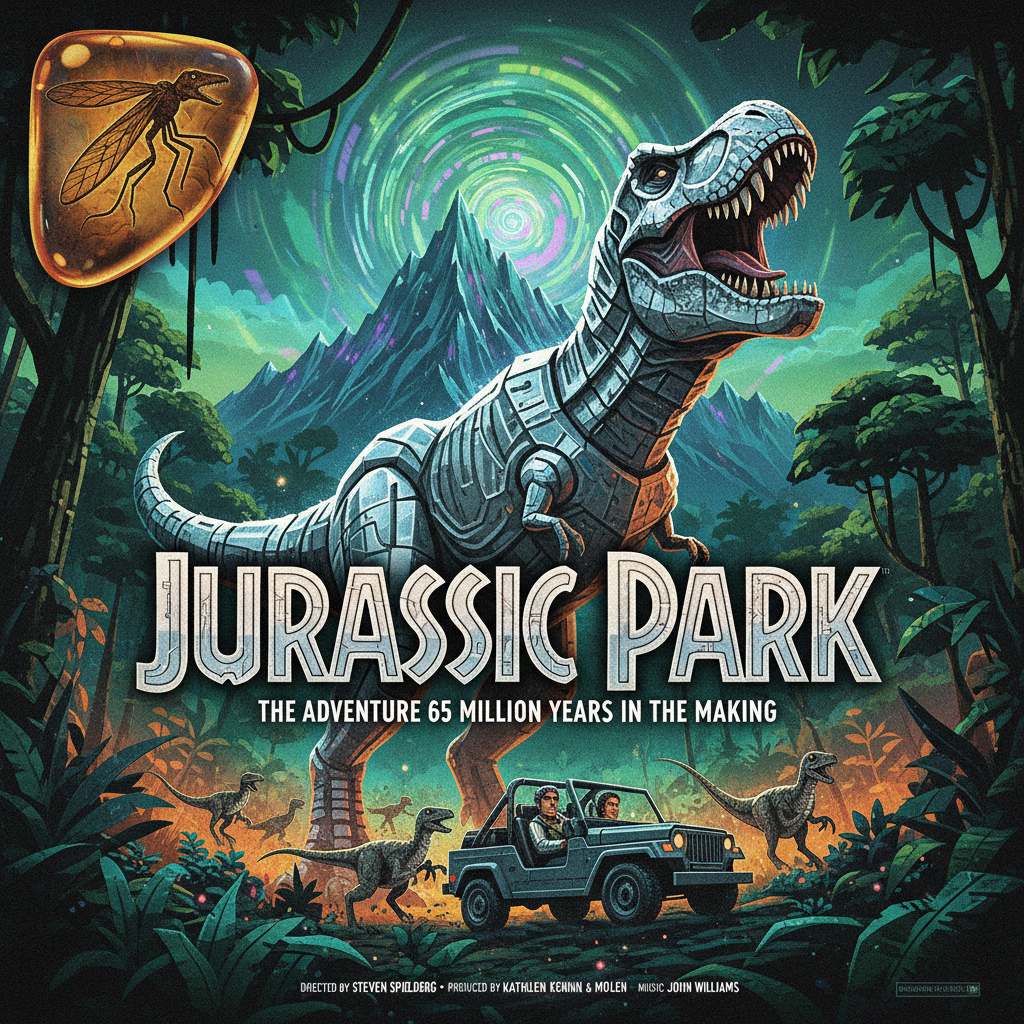

In [30]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

# YOUR CODE HERE - display the poster you saved


if output_path.exists():
    display(Image(filename=str(output_path), width=400))
else:
    print("Run the previous cell first to generate the image!")


---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

In [ ]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [ ]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # YOUR CODE HERE
    pass

In [ ]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
YOUR ORIGINAL MOVIE IDEA HERE - BE CREATIVE!
Describe the plot, characters, setting, visual style, and mood.
"""

# Uncomment to run:
# movie, poster_path = await movie_to_poster(my_movie_description)
# print(f"Generated poster for: {movie.title}")
# print(movie.model_dump_json(indent=2))
# display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!